<a href="https://colab.research.google.com/github/Riyajia/Machine_Learning-/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Trend Prediction and closing Price prediction using XGBoost and LSTM

##Importing libraries

Importing some of the required libraries
1. pandas library for data manupulation and analysis
2. matplotlib for ploting graphs and visualization 
3. math library for mathematical computation
4. importing warning library to supress warnings. 
5. XGBoost libraries and evaluation metrics library from Scikit learn
6. Libraries for LSTM models and evaluations from Keras


In [1]:
#import libraries
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import matplotlib.pyplot as plt
import math
import io

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

#For XGBoost model creation and evaluation
import xgboost as xgb
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix

#For LSTM model creation and evaluation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.metrics import mean_squared_error,  mean_absolute_error


## Data Exploration and Data Cleaning

Loading the dataset, the dataset was uploaded to Github first for easier loading of the data to Google Colab



In [2]:
url = "https://raw.githubusercontent.com/Riyajia/Machine_Learning-/main/indexData.csv"
df = pd.read_csv(url)

<font size = 3>Checking the first 5 rows of the dataset </font>

In [3]:
# The Head funtion shows thw first 5 rows of the dataset by default
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


<font size = 3>Checking the last 5 rows of the dataset </font>

In [4]:
# The Tail function shows the last 5 rows of the dataset by default. 
df.tail()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
112452,N100,2021-05-27,1241.119995,1251.910034,1241.119995,1247.069946,1247.069946,379696400.0
112453,N100,2021-05-28,1249.469971,1259.209961,1249.030029,1256.599976,1256.599976,160773400.0
112454,N100,2021-05-31,1256.079956,1258.880005,1248.140015,1248.930054,1248.930054,91173700.0
112455,N100,2021-06-01,1254.609985,1265.660034,1254.609985,1258.579956,1258.579956,155179900.0
112456,N100,2021-06-02,1258.489990,1263.709961,1258.239990,1263.619995,1263.619995,148465000.0


As the 'Date' coloumn in the dataset is an Object type, it is first converted to Data-Time type and then setting it as the Index. After that the original Date column is dropped.

In [5]:
# Changing the date type from object to Date Time type and setting the Date column as index
df.index = pd.to_datetime(df['Date'])
 
# dropping The original date column
df = df.drop(['Date'], axis='columns')

#Checking the change took effect
df.head()

,Index,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.0
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.0
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.0
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.0
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.0


Checking for the Unique values in the Index column (i.e. the different exchanges that are present in the dataset) that are present in the dataset. 

NOTE: The Index column is not be mixed with the Index of the dataset, it is just the column name that was given to the exchanges in the dataset. 

In [6]:
#Checking what Exchanges are present in the dataset. 
df['Index'].unique()


array(['NYA', 'IXIC', 'HSI', '000001.SS', 'GSPTSE', '399001.SZ', 'NSEI',
       'GDAXI', 'KS11', 'SSMI', 'TWII', 'J203.JO', 'N225', 'N100'],
      dtype=object)

Dropping rows with NaN(missing) values

In [7]:
#dropping rows with missing values
df.dropna(inplace=True)

Grouping the Stock Exchanges together and only selecting the ones required for this project
1. New York Stock Exchange- NYA 
2. NASDAQ - IXIC
3. Toronto Stock Exchange - GSPTSE


In [8]:
exchange = df.groupby(df.Index)

#NY stock market data
NYA = exchange.get_group("NYA")  

#NASDQ data
IXIC = exchange.get_group("IXIC") 

#Toronto Stock Market data
GSPTSE = exchange.get_group("GSPTSE")       

<font size = 3> Calculating a rolling average for 100 days of the closing column for all the three indices </font>

In [9]:
NYA['roll_avg_100'] = NYA['Close'].rolling(window = 100).mean()
IXIC['roll_avg_100']= IXIC['Close'].rolling(window = 100).mean()
GSPTSE['roll_avg_100'] = GSPTSE['Close'].rolling(window =100).mean()

<font size = 3> Calculating a rolling average for 200 days of the closing column for all the three indices </font>

In [10]:
NYA['roll_avg_200'] = NYA['Close'].rolling(window = 200).mean()
IXIC['roll_avg_200']= IXIC['Close'].rolling(window = 200).mean()
GSPTSE['roll_avg_200'] = GSPTSE['Close'].rolling(window = 200).mean()

Removing historic data (data before 1990)

In [11]:
NYA = NYA.loc["1990-01-01":].copy()
IXIC = IXIC.loc["1990-01-01":].copy()
GSPTSE = GSPTSE.loc["1990-01-01":].copy()

### Raw Data Visualization and rolling avg visualization

Ploting Closing price of New York, NASDAQ and Toronto Stock exchange with respect to date. This shows us that the market has risen quite high over the past few decades. 

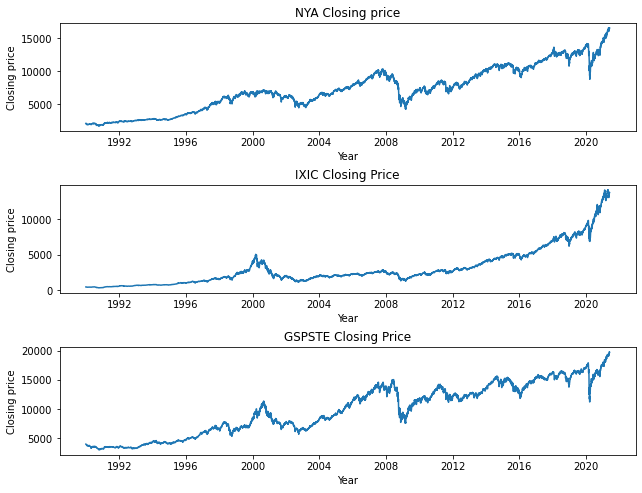

In [ ]:
#Stacking the 3 plots in one sections for easier comparison. 

plt.figure(figsize = (20,10))
plt.subplot(3,1,1)    
plt.plot(NYA['Close'])          
plt.title('NYA Closing price')
plt.xlabel("Year")
plt.ylabel("Closing price")

plt.subplot(3,1,2)       
plt.plot(IXIC['Close'])        
plt.title('IXIC Closing Price')
plt.xlabel("Year")
plt.ylabel("Closing price")

plt.subplot(3,1,3)      
plt.plot(GSPTSE['Close'])  
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.title('GSPSTE Closing Price')

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.5,
                    top=0.6,
                    wspace=0.5,
                    hspace=0.5)



Ploting the rolling average prices over the closing price. (If 100 days rolling average crosses over the 200 days rolling average then the market has an upward trend and vice-versa.)

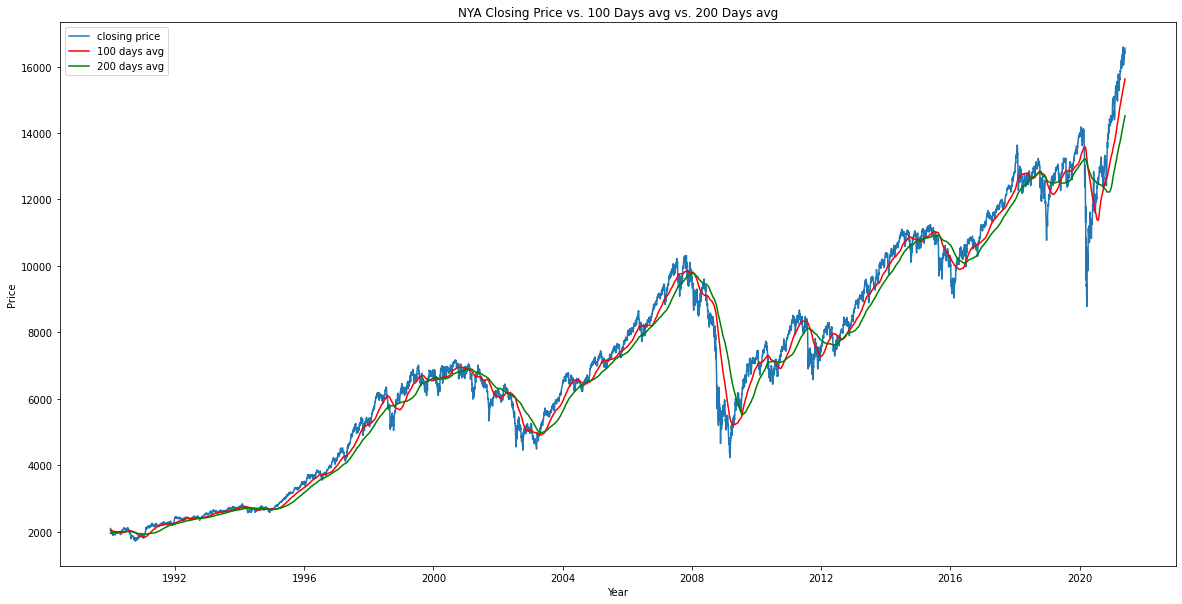

In [ ]:
#NYA plot

plt.figure(figsize=(20,10))
plt.plot(NYA['Close'], label = 'closing price')
plt.plot(NYA['roll_avg_100'], color = 'r', label = '100 days avg')
plt.plot(NYA['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('NYA Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

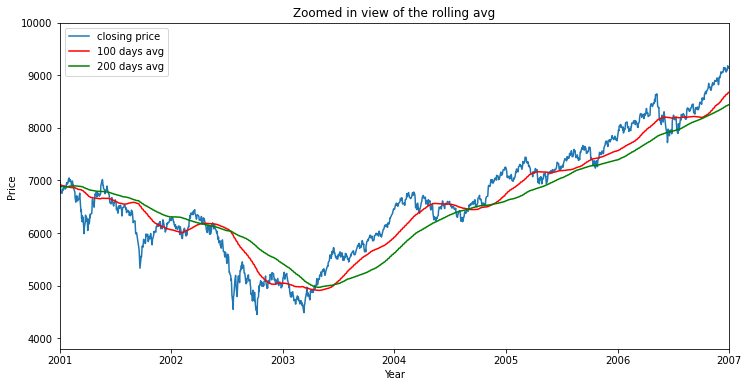

In [ ]:
#NYA plot
import datetime

plt.figure(figsize=(12,6))
plt.plot(NYA['Close'], label = 'closing price')
plt.plot(NYA['roll_avg_100'], color = 'r', label = '100 days avg')
plt.plot(NYA['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.xlim([datetime.date(2001,1,1),datetime.date(2007,1,1)])
plt.ylim(3800,10000)
plt.legend()
plt.title('Zoomed in view of the rolling avg')
plt.show()

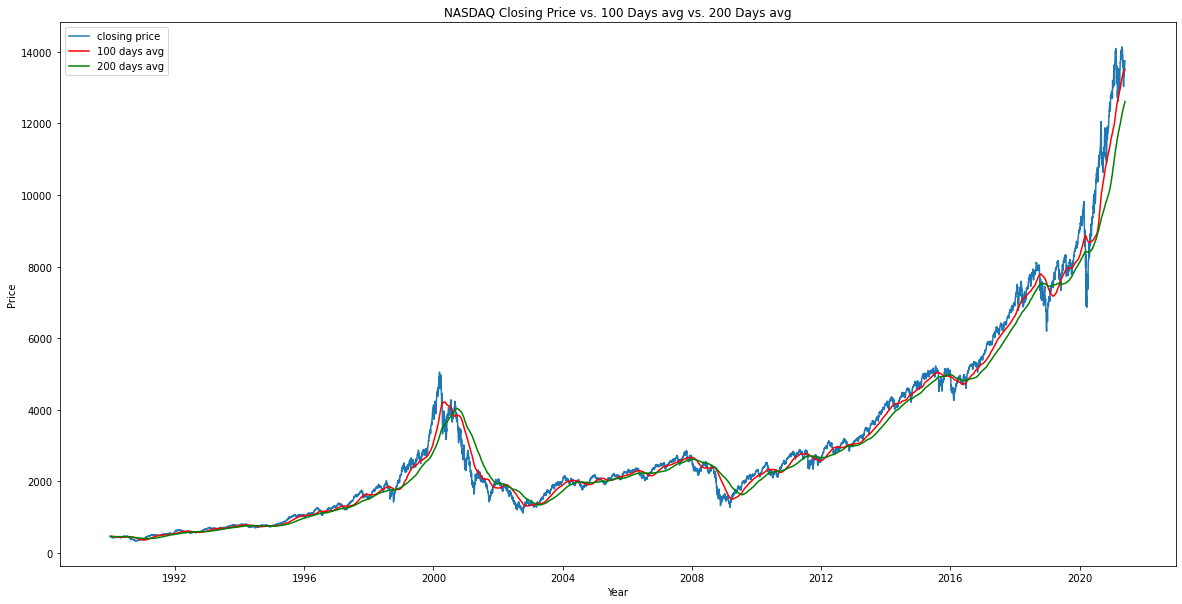

In [ ]:
#NASDAQ Plot
plt.figure(figsize=(20,10))
plt.plot(IXIC['Close'], label = 'closing price')
plt.plot(IXIC['roll_avg_100'], color = 'red', label = '100 days avg')
plt.plot(IXIC['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('NASDAQ Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

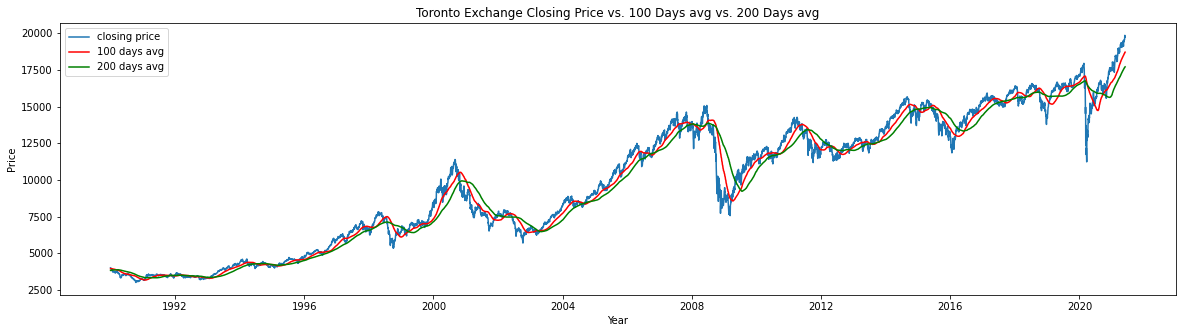

In [ ]:
#Toronto Stock Market Plot
plt.figure(figsize=(20,5))
plt.plot(GSPTSE['Close'], label = 'closing price')
plt.plot(GSPTSE['roll_avg_100'], color = 'red', label = '100 days avg')
plt.plot(GSPTSE['roll_avg_200'], color = 'green', label ='200 days avg' )
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend()
plt.title('Toronto Exchange Closing Price vs. 100 Days avg vs. 200 Days avg')
plt.show()

## XGBOOST

<font size = 4>Creating a **"Tomorrow"** column by shifting the data by 1 day from the close column and a **"Target"** column which has either 0 or 1 depending whether the value of tomorrow column is higher or lower than the close column on a particular day. These values will be used to predict the trend of the market.</font>

In [ ]:
#creating the tomorrow and target column for NYA

NYA["Tomorrow"] = NYA["Close"].shift(-1)
NYA["Target"] = (NYA["Tomorrow"] > NYA["Close"]).astype(int)


In [ ]:
#creating the tomorrow and target column for IXIC

IXIC["Tomorrow"] = IXIC["Close"].shift(-1)
IXIC["Target"]= (IXIC["Tomorrow"] > IXIC["Close"]).astype(int)


In [ ]:
#creating the tomorrow and target column for GSPTSE

GSPTSE["Tomorrow"] = GSPTSE["Close"].shift(-1)
GSPTSE["Target"]= (GSPTSE["Tomorrow"] > GSPTSE["Close"]).astype(int)


### XGBoost for New York Stock Exchange

Before training our Initial model for the **New York Stock Exchange** using XGBoost the following steps will be done as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.
4. Fitting the training data set to the model. 

In [ ]:
#Removing the columns that wont be required for our prediction
NYA  = NYA.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 85% for training and 20% testing
train_length = math.ceil(len(NYA) * .85) 
train_NYA = pd.DataFrame(NYA.iloc[:train_length])

# taking 15% of data for testing
test_NYA =pd.DataFrame(NYA.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]

Defining the initial model uisng XGBoost

In [ ]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [ ]:
model.fit(train_NYA[predictors], train_NYA['Target'])
predictions = model.predict(test_NYA[predictors])

Calculating the precision score and the accuracy score for the model. 

In [ ]:
print("Precision Score for our model is", round((precision_score(test_NYA["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_NYA["Target"],predictions)*100),2))

Precision Score for our model is 54.93
Accuracy Score for our model is 44.9


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later**

Hyperparameter tuning using Randomized Search 

In [ ]:
#Selecting the parameters to tune
"""
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
          "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [1000,1200,1500,2000,2500],  
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10]}
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [ ]:
#Creating the randomized search model. 
"""
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
"""

In [ ]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_NYA[predictors],train_NYA['Target'])
"""

In [ ]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

Redefining the model with the best estimators from the randomized search

In [ ]:
model_tuned = xgb.XGBClassifier(loss='exponential', 
                          n_estimators = 1000,  
                          criterion ='squared_error', 
                          max_depth = 10,
                          min_samples_split = 3,
                          colsample_bytree=0.3, 
                          gamma=0.1, 
                          learning_rate=0.05,
                          )

In [ ]:
model_tuned.fit(train_NYA[predictors], train_NYA['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='squared_error', gamma=0.1,
              learning_rate=0.05, loss='exponential', max_depth=10,
              min_samples_split=3, n_estimators=1000)

In [ ]:
predictions1 = model_tuned.predict(test_NYA[predictors])
predictions1 = pd.Series(predictions1, index=test_NYA.index)

In [ ]:
con_mat= confusion_matrix(test_NYA["Target"], predictions1)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
preds = pd.Series(predictions1, index=test_NYA.index, name="Predictions")
combined = pd.concat([test_NYA["Target"], preds], axis=1)
combined

In [ ]:
#predictions = pd.Series(predictions, index=test.index)

print("Precision Score for our model is", round((precision_score(test_NYA["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_NYA["Target"],preds)*100),2))

Precision Score for our model is 63.64
Accuracy Score for our model is 45.83


In [ ]:
#Making a Classification report for our model

print(classification_report(test_NYA["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.45      0.95      0.61       526
           1       0.64      0.06      0.12       661

    accuracy                           0.46      1187
   macro avg       0.54      0.51      0.36      1187
weighted avg       0.55      0.46      0.33      1187



### XGBoost for NASDAQ

Like before doing the same steps for **NASDAQ** stock Exchange using XGBoost the following steps will be done as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.
4. Fitting the training data set to the model. 

In [ ]:
#Removing the columns that wont be required for our prediction
IXIC  = IXIC.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 80% for training and 20% testing
train_length = math.ceil(len(IXIC) * .85) 
train_IXIC = pd.DataFrame(IXIC.iloc[:train_length])

# taking 15% of data for testing
test_IXIC =pd.DataFrame(IXIC.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]

Defining the initial model uisng XGBoost

In [ ]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [ ]:
model.fit(train_IXIC[predictors], train_IXIC['Target'])
predictions = model.predict(test_IXIC[predictors])

Calculating the precision score and the accuracy score for the model. 

In [ ]:
print("Precision Score for our model is", round((precision_score(test_IXIC["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_IXIC["Target"],predictions)*100),2))

Precision Score for our model is 50.0
Accuracy Score for our model is 42.54


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later**

Hyperparameter tuning using Randomized Search 

In [ ]:
#List of Parameters to tune
"""
params = {"learning_rate" : [0.05,0.10,0.15,0.20],
          "max_depth" : [ 3, 4, 5, 6, 10],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [1000,1200,1500,2000,2500],  
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10]}
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [ ]:
#Creating the randomized search model.
"""
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=6,verbose=3)
"""

In [ ]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_IXIC[predictors],train_IXIC['Target'])
"""

In [ ]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

XGBClassifier(colsample_bytree=0.4, criterion='mse', gamma=0.0,
              learning_rate=0.15, loss='exponential', max_depth=5,
              min_child_weight=3, min_samples_split=5, n_estimators=2500)

Redefining the model with the best estimators from the randomized search

In [ ]:
model_tuned = xgb.XGBClassifier(loss='exponential', 
                          n_estimators = 1000,  
                          criterion ='friedman_mse', 
                          max_depth = 10,
                          min_samples_split = 10,
                          min_child_weight=7,
                          colsample_bytree=0.3, 
                          gamma=0.0, 
                          learning_rate=0.05,
                          )

Fitting the tuned model

In [ ]:
model_tuned.fit(train_IXIC[predictors], train_IXIC['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='friedman_mse', gamma=0.0,
              learning_rate=0.05, loss='exponential', max_depth=10,
              min_child_weight=7, min_samples_split=10, n_estimators=1000)

Doing the predictions

In [ ]:
predictions1 = model_tuned.predict(test_IXIC[predictors])
predictions1 = pd.Series(predictions1, index=test_IXIC.index)

Creating the Confusion matrix and plotting the matrix

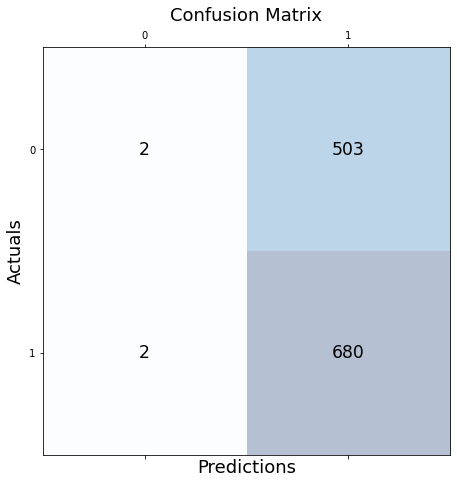

In [ ]:
con_mat= confusion_matrix(test_IXIC["Target"], predictions1)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Converting the predictions into a Pandas series and then combining into a table with the Target Column. 

In [ ]:
preds = pd.Series(predictions1, index=test_IXIC.index, name="Predictions")
combined = pd.concat([test_IXIC["Target"], preds], axis=1)
combined

,Target,Predictions
Date,,
2016-09-12,0,1
2016-09-13,1,1
2016-09-14,1,0
2016-09-15,0,1
2016-09-16,0,1
...,...,...
2021-05-24,0,1
2021-05-25,1,1
2021-05-26,0,1


Calculating the Precision Score and Accuracy Score

In [ ]:
print("Precision Score for our model is", round((precision_score(test_IXIC["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_IXIC["Target"],preds)*100),2))

Precision Score for our model is 57.48
Accuracy Score for our model is 57.46


In [ ]:
#Making a Classification report for our model

print(classification_report(test_IXIC["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       505
           1       0.57      1.00      0.73       682

    accuracy                           0.57      1187
   macro avg       0.54      0.50      0.37      1187
weighted avg       0.54      0.57      0.42      1187



### XGBoost for Toronto Stock Exchange

Doing the same steps again for **Toronto Stock Exchange** XGBoost will be used for trend prediction as well and before that the following steps are taken as part of data preprocessing. 

1. Dropping the coloums that wont be used for the predictions 
2. Splitting the data into training (85%) and test (15%) datasets. 
3. Using Close, open, high and low as our predictors.
4. Fitting the training data set to the model. 

In [ ]:
#Removing the columns that wont be required for our prediction
GSPTSE  = GSPTSE.drop(columns=['Adj Close', 'Volume'])

# Splitting the dataset in 80% for training and 20% testing
train_length = math.ceil(len(GSPTSE) * .85) 
train_GSPTSE = pd.DataFrame(GSPTSE.iloc[:train_length])

# taking 15% of data for testing
test_GSPTSE =pd.DataFrame(GSPTSE.iloc[train_length:])

#selecting the predictors for our model
predictors = ["Open", "Close", "High", "Low"]

Defining the initial model uisng XGBoost

In [ ]:
#Defining the initial model
model = xgb.XGBClassifier(loss='log_loss', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 5,
                          min_samples_split = 3,
                          max_feature = "auto",
                          gamma=0.0, 
                          learning_rate=0.25)

Fitting the model with the training dataset and predicting the values of the test dataset 

In [ ]:
model.fit(train_GSPTSE[predictors], train_GSPTSE['Target'])
predictions = model.predict(test_GSPTSE[predictors])

Calculating the precision score and the accuracy score for the model. 

In [ ]:
print("Precision Score for our model is", round((precision_score(test_GSPTSE["Target"],predictions)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_GSPTSE["Target"],predictions)*100),2))

Precision Score for our model is 57.76
Accuracy Score for our model is 47.21


**The next 4 cells of codes are commented out as I have used Randomized Search instead of Grid Search and it gives different set of best estimators everytime it runs. The Best parameters that I have found so far has been used as the tuned model later.**

Hyperparameter tuning using Randomized Search 

In [ ]:
"""
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
          "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
          "loss": ['log_loss', 'exponential'],
          "n_estimators" : [500, 800, 1000,1200,1500], 
          "criterion" :['friedman_mse', 'squared_error', 'mse'], 
          "min_samples_split" : [2,3,4,5,10]}
"""

Creating the Randomized Serach model for Hypertuning and fitting the training dataset to the model and printing the best parameters that the model has found. 

In [ ]:
"""
#Creating the randomized search model. 
classifier = xgb.XGBClassifier()
rs_model=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
"""

In [ ]:
#Fitting the randomized search model with training data
"""
rs_model.fit(train_GSPTSE[predictors],train_GSPTSE['Target'])
"""

In [ ]:
#printing the best estimators that the model has found. 
"""
rs_model.best_estimator_
"""

Redefining the model with the best estimators from the randomized search

In [ ]:
model_tuned = xgb.XGBClassifier(loss='exponential', 
                          n_estimators = 1000,  
                          criterion ='mse', 
                          max_depth = 8,
                          min_samples_split = 2,
                          min_child_weight=5,
                          colsample_bytree=0.4, 
                          gamma=0.0, 
                          learning_rate=0.05,
                          )

In [ ]:
model_tuned.fit(train_GSPTSE[predictors], train_GSPTSE['Target'])

XGBClassifier(colsample_bytree=0.3, criterion='mse', gamma=0.0,
              learning_rate=0.05, loss='exponential', max_depth=8,
              min_child_weight=5, min_samples_split=2, n_estimators=1000)

Predicting using the tuned model

In [ ]:
predictions1 = model_tuned.predict(test_GSPTSE[predictors])
predictions1 = pd.Series(predictions1, index=test_GSPTSE.index)

Creating and Plotting the confusion matrix

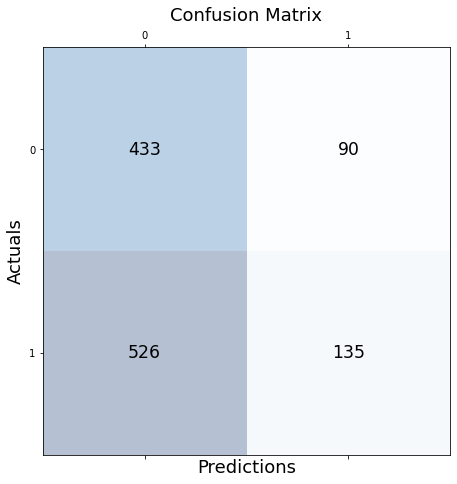

In [ ]:
con_mat= confusion_matrix(test_GSPTSE["Target"], predictions1)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(con_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(con_mat.shape[0]):
    for j in range(con_mat.shape[1]):
        ax.text(x=j, y=i,s=con_mat[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
preds = pd.Series(predictions1, index=test_GSPTSE.index, name="Predictions")
combined = pd.concat([test_GSPTSE["Target"], preds], axis=1)
combined

,Target,Predictions
Date,,
2016-09-12,0,0
2016-09-13,1,0
2016-09-14,1,0
2016-09-15,0,1
2016-09-16,1,0
...,...,...
2021-05-25,1,0
2021-05-26,1,0
2021-05-27,1,0


In [ ]:
#recalculating the precision score and accuracy score

print("Precision Score for our model is", round((precision_score(test_GSPTSE["Target"],preds)*100),2))
print("Accuracy Score for our model is", round((accuracy_score(test_GSPTSE["Target"],preds)*100),2))

Precision Score for our model is 60.0
Accuracy Score for our model is 47.97


In [ ]:
#Making a Classification report for the model

print(classification_report(test_GSPTSE["Target"],preds, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.45      0.83      0.58       523
           1       0.60      0.20      0.30       661

    accuracy                           0.48      1184
   macro avg       0.53      0.52      0.44      1184
weighted avg       0.53      0.48      0.43      1184



## Long Short-Term Memory(LSTM)

Using LSTM to predict prices of the 3 Stock exchnages. 

* Only keeping the close column for the price prediction using LSTM


In [12]:
#Selecting just the Close columns for our model
NYA = NYA[['Close']]
IXIC = IXIC[['Close']]
GSPTSE = GSPTSE[['Close']]


### LSTM for New York Stock Exchange

Predicting the NYA stock exchange in the following cells. Steps taken are as follows

*   Splitting the dataset into training and testing data sets
*   Scaling the data using Standard Scaler
*   Training dataset and testing dataset will both be divided into features and labels subset
*   Creating the LSTM model
*   Fitting data to the model
*   Ploting the training loss and actual vs. predicted prices
*   Calculating the mean squared error for both the training and test predictions. 

In [13]:
# taking 85% of the total data for training so the rest 15% will be for testing
train_length = math.ceil(len(NYA) * .85) 
NYA_train = NYA.iloc[:train_length]

# taking 15% of data for testing
NYA_test = NYA.iloc[train_length:]

print(NYA_train.shape)
print(NYA_test.shape)


(6727, 1)
(1187, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [14]:
#Data scaling
scaled_train_NYA = sc.fit_transform(NYA_train)
print(scaled_train_NYA.shape)


(6727, 1)


Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

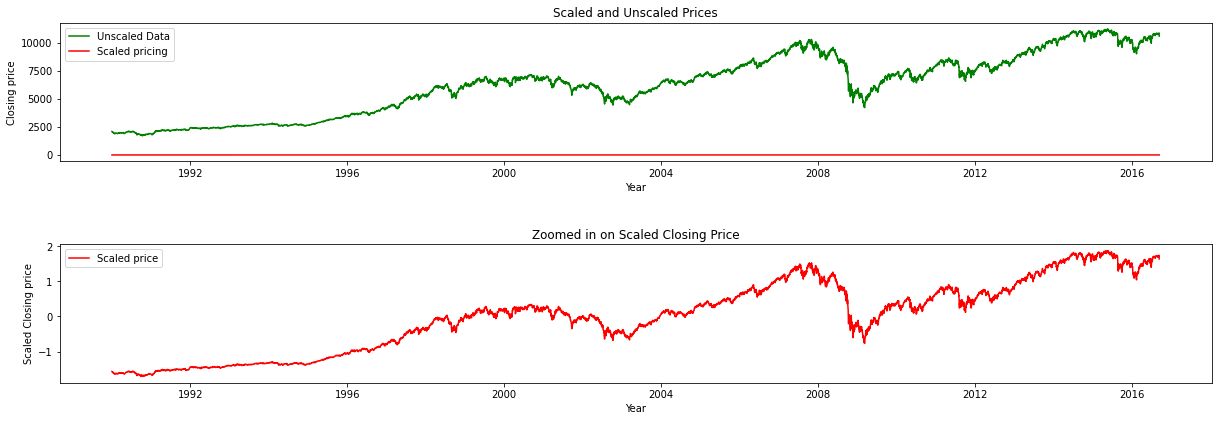

In [15]:
scaled_NYA_df = pd.DataFrame(scaled_train_NYA, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
#plt.plot(NYA_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(NYA_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(NYA_train.index, scaled_NYA_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(NYA_train.index,scaled_NYA_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Where Y train will be the data of Day 101 and so on till the end of the dataset. 
With this kind of division the target value is considered to be dependent on the data of the previous 100 days.

In [16]:
window = 100       #timestep window
X_train_NYA = []
y_train_NYA = []

for i in range(window,len(scaled_train_NYA)): 
    X_train_NYA.append(scaled_train_NYA[(i-window):i,0])
    y_train_NYA.append(scaled_train_NYA[i,0])

X_train_NYA, y_train_NYA = np.array(X_train_NYA),np.array(y_train_NYA)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [17]:
X_train_NYA = np.reshape(X_train_NYA, (X_train_NYA.shape[0],X_train_NYA.shape[1],1))
X_train_NYA.shape

(6627, 100, 1)

<font size = 3>Creating the LSTM model </font>

In [18]:
model = Sequential()

model.add(LSTM(units=100,activation = 'relu', return_sequences= True, 
               input_shape = (X_train_NYA.shape[1],1)))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units= 100, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units= 1))
model.compile(optimizer='adam',loss='mean_squared_error')

Fitting the model with training data

In [19]:
epochs = 30
hist_NYA = model.fit(X_train_NYA,
                 y_train_NYA,
                 epochs= epochs, 
                 batch_size=32, 
                 verbose= 1)  

Epoch 1/30
208/208 [==============================] - 45s 197ms/step - loss: 0.1052
Epoch 2/30
208/208 [==============================] - 42s 204ms/step - loss: 0.0177
Epoch 3/30
208/208 [==============================] - 42s 202ms/step - loss: 0.0161
Epoch 4/30
208/208 [==============================] - 41s 197ms/step - loss: 0.0150
Epoch 5/30
208/208 [==============================] - 41s 197ms/step - loss: 0.0136
Epoch 6/30
208/208 [==============================] - 41s 196ms/step - loss: 0.0137
Epoch 7/30
208/208 [==============================] - 41s 199ms/step - loss: 0.0124
Epoch 8/30
208/208 [==============================] - 42s 200ms/step - loss: 0.0118
Epoch 9/30
208/208 [==============================] - 41s 199ms/step - loss: 0.0120
Epoch 10/30
208/208 [==============================] - 44s 210ms/step - loss: 0.0116
Epoch 11/30
208/208 [==============================] - 41s 197ms/step - loss: 0.0119
Epoch 12/30
208/208 [==============================] - 41s 198ms/step - lo

Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [20]:
train_loss = np.array(hist_NYA.history['loss'])

*  Ploting the loss for each epoch





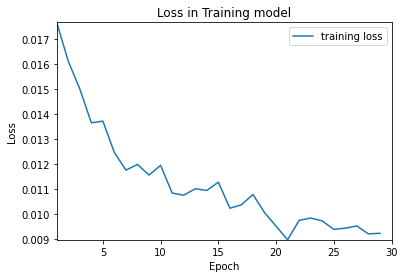

In [21]:

plt.plot(hist_NYA.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, epochs)
plt.ylim(train_loss.min(),train_loss[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()

Appending the past 60 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 60 days as we have set the model with 60 days timestep. 

In [22]:
past_100_days = NYA_train.tail(100)
appended_NYA_test = past_100_days.append(NYA_test)

Scaling the test data before doing the predictions. 

In [23]:
scaled_test_NYA = sc.fit_transform(appended_NYA_test)


Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 100 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 101st day in the test dataset. 

In [24]:
X_test_NYA = []
y_test_NYA = []

for i in range(window,len(scaled_test_NYA)):
    X_test_NYA.append(scaled_test_NYA[(i-window):i,0])
    y_test_NYA.append(scaled_test_NYA[i,0])

X_test_NYA, y_test_NYA = np.array(X_test_NYA), np.array(y_test_NYA)

X_test_NYA = np.reshape(X_test_NYA,(X_test_NYA.shape[0], X_test_NYA.shape[1],1))
y_test_NYA= y_test_NYA.reshape(-1,1)
print(X_test_NYA.shape)
print(y_test_NYA.shape)



(1187, 100, 1)
(1187, 1)


Data reshaping for prediction and plotting

In [25]:
#reshaping the data for prediction
X_test_NYA = np.reshape(X_test_NYA,(X_test_NYA.shape[0], X_test_NYA.shape[1],1))
y_test_NYA= y_test_NYA.reshape(-1,1)

Predicting the price for the test 'labels' i.e. y-test values. 

In [26]:
#Predictions
y_train_prediction = model.predict(X_train_NYA)
y_predict_NYA = model.predict(X_test_NYA)


38/38 [==============================] - 2s 52ms/step


Transforming the predicted values back to the unscaled form. 

In [27]:
#reshaping the train data for transformation
y_train_NYA = y_train_NYA.reshape(-1,1)

#transform training data back to original form
predicted_train_NYA= sc.inverse_transform(y_train_prediction)
train_NYA= sc.inverse_transform(y_train_NYA)

#transform testing data back to original form
predicted_NYA= sc.inverse_transform(y_predict_NYA)
test_NYA= sc.inverse_transform(y_test_NYA)


Calculating the percentage difference between predicted and the actual price.

In [29]:
NYA_test["Predicted"] = predicted_NYA

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

NYA_test["Percentage_diff"] =  percentage_change(NYA_test["Predicted"],NYA_test["Close"]) 
NYA_test

,Close,Predicted,Percentage_diff
Date,,,
2016-09-12,10741.24023,10851.504883,1.016123
2016-09-13,10535.36035,10849.869141,2.898733
2016-09-14,10511.40039,10842.935547,3.057614
2016-09-15,10602.94043,10830.840820,2.104180
2016-09-16,10532.26953,10816.005859,2.623300
...,...,...,...
2021-05-24,16464.68945,15938.635742,3.300494
2021-05-25,16390.18945,15943.554688,2.801350
2021-05-26,16451.96094,15948.028320,3.159843


Plotting the actual price vs the predicted price

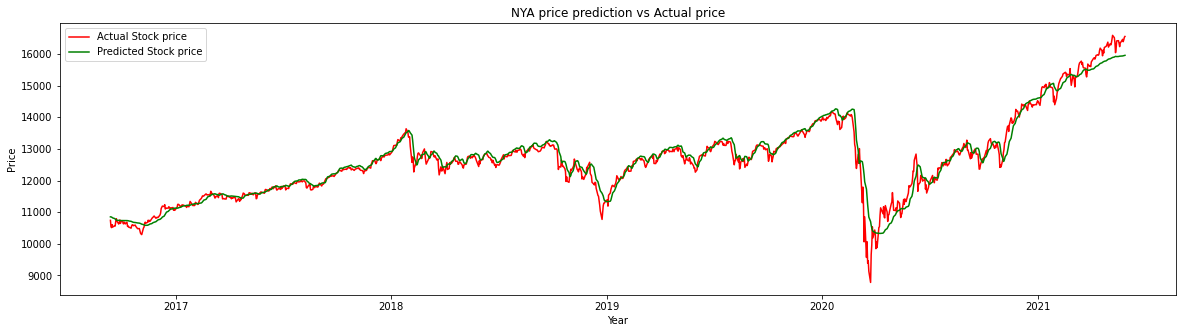

In [52]:
plt.figure(figsize= (20,5))
plt.plot(NYA_test.index, NYA_test['Close'], color = 'red', label = 'Actual Stock price')
plt.plot(NYA_test['Predicted'], color = 'green', label = 'Predicted Stock price')
plt.title('NYA price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

Plotting the percentage difference between the prices. 

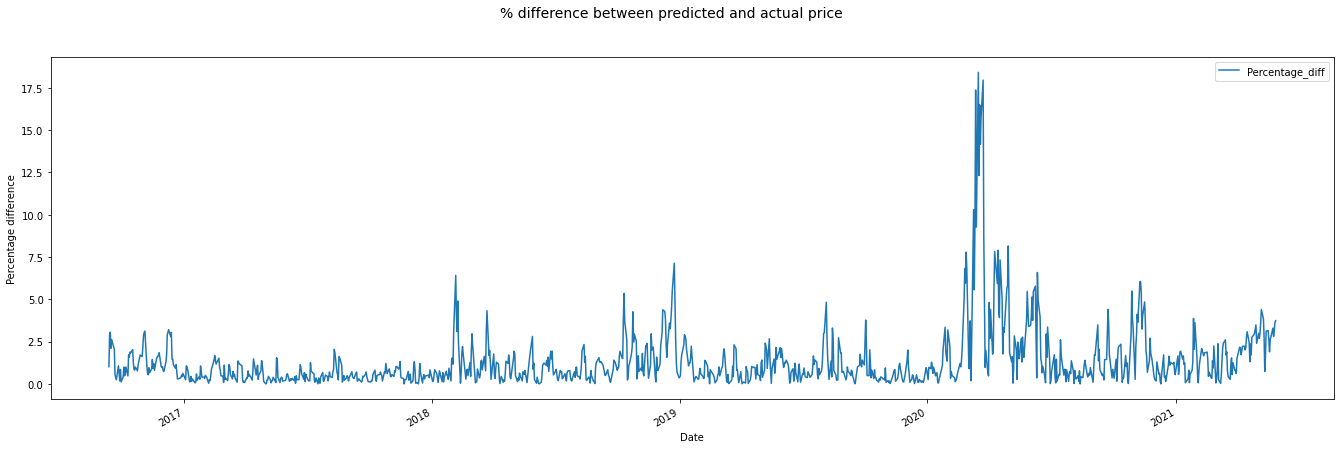

In [30]:
NYA_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize=14, color='black')
plt.ylabel("Percentage difference")
plt.show()

Evaluating the model

In [31]:
#Finding the Root Mean Squared error and Mean absolute error on the predictions

#Training data
print("Evaluations of the training data:")
print("RMSE of the training prediction:", math.sqrt(mean_squared_error(train_NYA, predicted_train_NYA)))
print("MAE of the training prediction:", mean_absolute_error(train_NYA, predicted_train_NYA))
print()
#Testing data
print("Evaluations of the testing data:")
print("RMSE of the testing prediction:", math.sqrt(mean_squared_error(test_NYA, predicted_NYA)))
print("MAE of the testing prediction:", mean_absolute_error(test_NYA, predicted_NYA))

Evaluations of the training data:
RMSE of the training prediction: 133.28555180251684
MAE of the training prediction: 112.2357884451036

Evaluations of the testing data:
RMSE of the testing prediction: 268.82094079098755
MAE of the testing prediction: 165.2681160668176


### LSTM for NASDAQ exchange

Predicting the IXIC(NASDAQ) stock exchange in the following cells. Steps taken are as follows

* Splitting the dataset into training and testing data sets
* Scaling the data using Standard Scaler
* Training dataset and testing dataset will both be divided into features and labels subset
* Creating the LSTM model
* Fitting data to the model
* Ploting the training loss and actual vs. predicted prices
* Calculating the mean squared error for both the training and test predictions.

In [32]:
train_length_IXIC = math.ceil(len(IXIC) * .85) 
IXIC_train = IXIC.iloc[:train_length_IXIC]

# taking 15% of data for testing
IXIC_test = IXIC.iloc[train_length_IXIC:]

print(IXIC_train.shape)
print(IXIC_test.shape)

(6727, 1)
(1187, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [33]:
scaled_train_IXIC = sc.fit_transform(IXIC_train)
scaled_train_IXIC.shape

(6727, 1)

Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

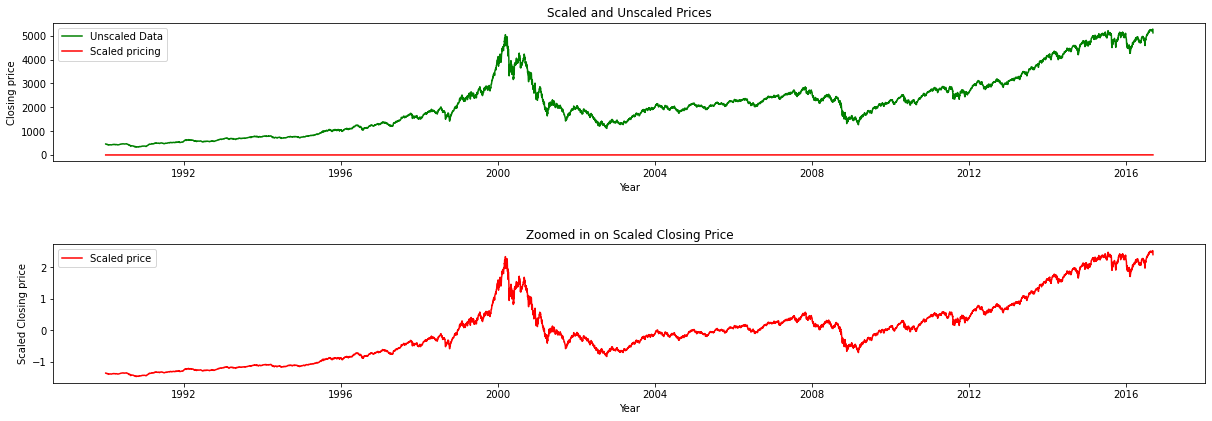

In [34]:
scaled_IXIC_df = pd.DataFrame(scaled_train_IXIC, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
plt.plot(IXIC_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(IXIC_train.index, scaled_IXIC_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(IXIC_train.index,scaled_IXIC_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Where Y train will be the data of Day 61. With this division the target value is considered to be dependent on the data of the previous 60 days and so on for the full data set. 

In [35]:
window = 100
X_train_IXIC = []
y_train_IXIC = []

for i in range(window,len(scaled_train_IXIC)): 
    X_train_IXIC.append(scaled_train_IXIC[(i-window):i,0])
    y_train_IXIC.append(scaled_train_IXIC[i,0])

X_train_IXIC, y_train_IXIC = np.array(X_train_IXIC),np.array(y_train_IXIC)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [36]:
X_train_IXIC = np.reshape(X_train_IXIC, (X_train_IXIC.shape[0],X_train_IXIC.shape[1],1))
X_train_IXIC.shape

(6627, 100, 1)

<font size = 3>Creating the LSTM model </font>

In [37]:
model = Sequential()

model.add(LSTM(units=100,activation = 'relu', return_sequences= True, 
               input_shape = (X_train_IXIC.shape[1],1)))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units= 100, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units= 1))
model.compile(optimizer='adam',loss='mean_squared_error')


Fitting the model with training data

In [38]:
epochs = 30
hist_IXIC = model.fit(X_train_IXIC,
                 y_train_IXIC,
                 epochs= epochs, 
                 batch_size=32, 
                 verbose= 1)  #using verbose=2 to see the loss in each step.

Epoch 1/30
208/208 - 43s - loss: 11082001.0000 - 43s/epoch - 208ms/step
Epoch 2/30
208/208 - 40s - loss: 0.2208 - 40s/epoch - 191ms/step
Epoch 3/30
208/208 - 40s - loss: 0.0841 - 40s/epoch - 192ms/step
Epoch 4/30
208/208 - 41s - loss: 0.0624 - 41s/epoch - 195ms/step
Epoch 5/30
208/208 - 40s - loss: 0.0402 - 40s/epoch - 191ms/step
Epoch 6/30
208/208 - 40s - loss: 0.0283 - 40s/epoch - 191ms/step
Epoch 7/30
208/208 - 40s - loss: 0.0252 - 40s/epoch - 191ms/step
Epoch 8/30
208/208 - 40s - loss: 0.0228 - 40s/epoch - 191ms/step
Epoch 9/30
208/208 - 40s - loss: 0.0221 - 40s/epoch - 193ms/step
Epoch 10/30
208/208 - 39s - loss: 0.0204 - 39s/epoch - 189ms/step
Epoch 11/30
208/208 - 40s - loss: 0.0194 - 40s/epoch - 191ms/step
Epoch 12/30
208/208 - 40s - loss: 0.0190 - 40s/epoch - 190ms/step
Epoch 13/30
208/208 - 39s - loss: 0.0182 - 39s/epoch - 190ms/step
Epoch 14/30
208/208 - 40s - loss: 0.0184 - 40s/epoch - 193ms/step
Epoch 15/30
208/208 - 39s - loss: 0.0168 - 39s/epoch - 190ms/step
Epoch 16/30


Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [39]:
train_loss2 = np.array(hist_IXIC.history['loss'])

*  Ploting the loss for each epoch





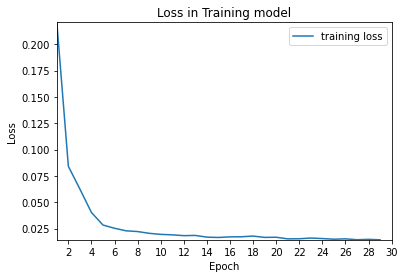

In [40]:
plt.plot(hist_IXIC.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,31,2))
plt.ylabel('Loss')
plt.xlim(1,epochs)
plt.ylim(train_loss2.min(),train_loss2[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()


Appending the past 100 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 100 days as we have set the model with 100 days timestep. 

In [42]:
past_100_days = IXIC_train.tail(100)
appended_IXIC_test = past_100_days.append(IXIC_test)

Scaling the test data before doing the predictions. 

In [43]:
scaled_testDataIXIC = sc.fit_transform(appended_IXIC_test)

scaled_testDataIXIC.shape


(1287, 1)

Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 100 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 101st day in the test dataset. 

In [44]:
X_test_IXIC = []
y_test_IXIC = []

for i in range(window,len(scaled_testDataIXIC)):
    X_test_IXIC.append(scaled_testDataIXIC[(i-window):i,0])
    y_test_IXIC.append(scaled_testDataIXIC[i,0])

X_test_IXIC, y_test_IXIC = np.array(X_test_IXIC), np.array(y_test_IXIC)

Data reshaping for prediction and plotting

In [45]:
#reshaping the data for prediction
X_test_IXIC = np.reshape(X_test_IXIC,(X_test_IXIC.shape[0], X_test_IXIC.shape[1],1))
y_test_IXIC = y_test_IXIC.reshape(-1,1)

print(X_test_IXIC.shape)
print(y_test_IXIC.shape)

(1187, 100, 1)
(1187, 1)


Predicting the price for the test 'labels' i.e. y-test values. 

In [46]:
#Predictions
y_train_predict_IXIC = model.predict(X_train_IXIC)
y_test_predict_IXIC = model.predict(X_test_IXIC)


38/38 [==============================] - 2s 49ms/step


Transforming the predicted values back to the unscaled form. 

In [47]:
#reshaping the train data
y_train_IXIC = y_train_IXIC.reshape(-1,1)

#transforming train set back to original form
predicted_train_IXIC = sc.inverse_transform(y_train_predict_IXIC)
train_IXIC = sc.inverse_transform(y_train_IXIC)

#transforming test set back to original form
predicted_IXIC= sc.inverse_transform(y_test_predict_IXIC)
test_IXIC= sc.inverse_transform(y_test_IXIC)


Creating a new column with the predicted values along with the actual closing price of the Test dataset and calculating the percentage difference between the prices. 

In [49]:
IXIC_test["Predicted"] = predicted_IXIC

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

IXIC_test["Percentage_diff"] =  percentage_change(IXIC_test["Predicted"],IXIC_test["Close"]) 
IXIC_test

,Close,Predicted,Percentage_diff
Date,,,
2016-09-12,5211.890137,5215.293457,0.065257
2016-09-13,5155.250000,5216.772461,1.179320
2016-09-14,5173.770020,5215.066406,0.791867
2016-09-15,5249.689941,5210.308105,0.755845
2016-09-16,5244.569824,5204.242676,0.774890
...,...,...,...
2021-05-24,13661.169920,13218.839844,3.346210
2021-05-25,13657.169920,13249.203125,3.079180
2021-05-26,13738.000000,13289.712891,3.373189


Plotting the actual price vs the predicted price

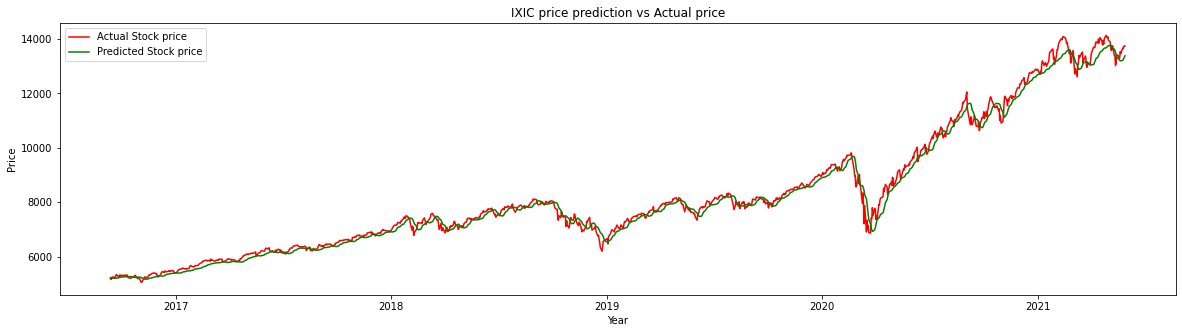

In [50]:
plt.figure(figsize= (20,5))
plt.plot(IXIC_test.index,IXIC_test["Close"], color = 'red', label = 'Actual Stock price')
plt.plot(IXIC_test["Predicted"], color = 'green', label = 'Predicted Stock price')
plt.title('IXIC price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

Plotting the percentage difference between the prices. 

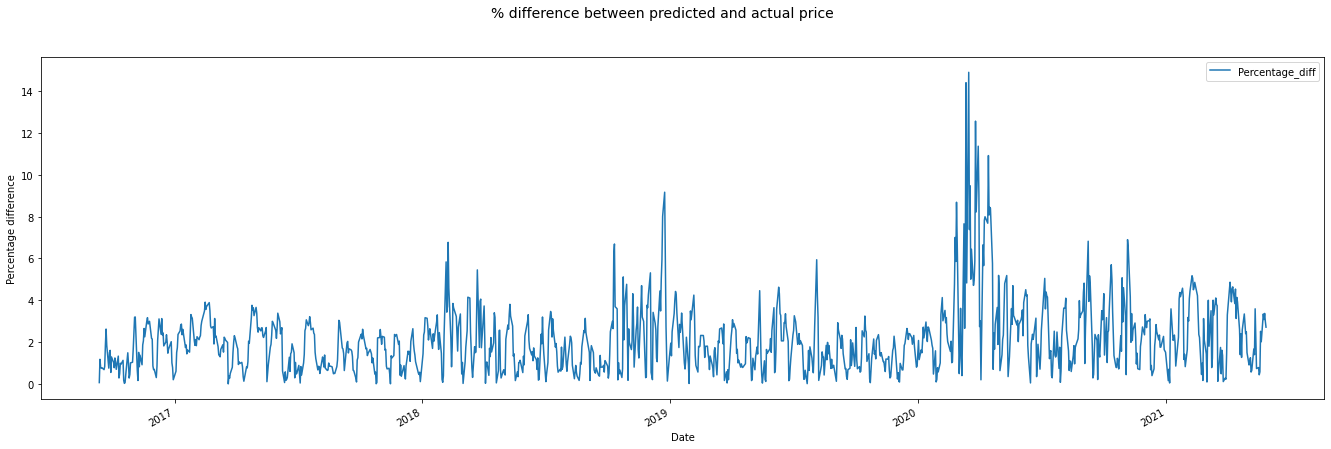

In [53]:
IXIC_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize=14, color='black')
plt.ylabel("Percentage difference")
plt.show()

Evaluating the model

In [80]:
#Finding the Root Mean Squared error on the training data
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Finding the Mean Squared error on the scaled testing data
print("Evaluating the training predictions:")
print("RMSE of the testing prediction:", math.sqrt(mean_squared_error(train_IXIC, predicted_train_IXIC)))
print("MAE of the testing prediction:", mean_absolute_error(train_IXIC, predicted_train_IXIC))
print()
#Finding the Mean Squared error on the unscaled testing data
print("Evaluating the testing predictions:")
print("RMSE of the testing prediction:", math.sqrt(mean_squared_error(test_IXIC, predicted_IXIC)))
print("MAE of the testing prediction:", mean_absolute_error(test_IXIC, predicted_IXIC))

Evaluating the training predictions:
RMSE of the testing prediction: 139.75347156448947
MAE of the testing prediction: 100.83102198819275

Evaluating the testing predictions:
RMSE of the testing prediction: 231.8666180135653
MAE of the testing prediction: 174.4585656102306


### LSTM for Toronto Stock Exchange

Predicting the GSPTSE(Toronto Exchange) stock exchange in the following cells. Steps taken are as follows

* Splitting the dataset into training and testing data sets
* Scaling the data using Standard Scaler
* Training dataset and testing dataset will both be divided into features and labels subset
* Creating the LSTM model
* Fitting data to the model
* Ploting the training loss and actual vs. predicted prices
* Calculating the mean squared error for both the training and test predictions.

In [55]:
train_length_GSPTSE = math.ceil(len(GSPTSE) * .8) 

#taking 80% of the data for training
GSPTSE_train = GSPTSE.iloc[:train_length_GSPTSE]

# taking 20% of data for testing
GSPTSE_test = GSPTSE.iloc[train_length_GSPTSE:]

print(GSPTSE_train.shape)
print(GSPTSE_test.shape)

(6320, 1)
(1579, 1)


Scaling the data using Standard Scaler. Using a scaled data allows the algorithm to converge faster as the feature values are closer to normal distribution. 

In [56]:
scaled_train_GSPTSE = sc.fit_transform(GSPTSE_train)
scaled_train_GSPTSE.shape

(6320, 1)

Plotting the Scaled data with the actual data to show the difference between them. Also in a different graph plotted just the scaled data to show that even though it is scaled it has the same pattern as the original data. 

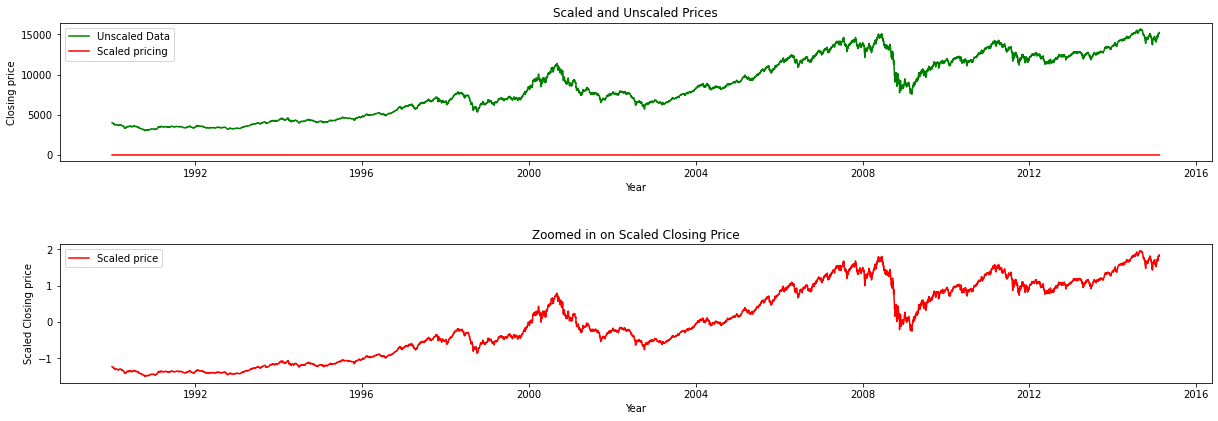

In [57]:
scaled_GSPTSE_df = pd.DataFrame(scaled_train_GSPTSE, columns = ['Scaled Price'])

plt.figure(figsize = (20,5))
plt.subplot(2,1,1)    
plt.plot(GSPTSE_train["Close"], label = "Unscaled Data", color = 'green')
plt.plot(GSPTSE_train.index, scaled_GSPTSE_df["Scaled Price"], label = 'Scaled pricing', color='red')
plt.title('Scaled and Unscaled Prices')
plt.xlabel("Year")
plt.ylabel("Closing price")
plt.legend()

plt.subplot(2,1,2)       
plt.plot(GSPTSE_train.index,scaled_GSPTSE_df["Scaled Price"], label = 'Scaled price', color='red')       
plt.title('Zoomed in on Scaled Closing Price')
plt.xlabel("Year")
plt.ylabel("Scaled Closing price")

plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.6,
                    hspace=0.6)

plt.legend()
plt.show()

Dividing the training data into X train(features) and Y train(labels). Where Y train will be the data of Day 101 sliding forward for the full dataset. 
With this division the target value is considered to be dependent on the data of the previous 100 days and so on for the full data set. 

In [58]:
X_train_GSPTSE= []
y_train_GSPTSE = []

for i in range(window,len(scaled_train_GSPTSE)): 
    X_train_GSPTSE.append(scaled_train_GSPTSE[(i-window):i,0])
    y_train_GSPTSE.append(scaled_train_GSPTSE[i,0])

X_train_GSPTSE, y_train_GSPTSE = np.array(X_train_GSPTSE),np.array(y_train_GSPTSE)

Re-shaping the 1 dimentional numpy array into 3-dimentional array as LSTM model requires an input in 3 dimensions. 

In [59]:
X_train_GSPTSE = np.reshape(X_train_GSPTSE, (X_train_GSPTSE.shape[0],X_train_GSPTSE.shape[1],1))
X_train_GSPTSE.shape

(6220, 100, 1)

<font size = 3>Creating the LSTM model </font>

In [60]:
model = Sequential()

model.add(LSTM(units=100,activation = 'relu', return_sequences= True, input_shape = (X_train_GSPTSE.shape[1],1)))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.1))

model.add(LSTM(units= 100,activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units= 100, activation = 'relu', return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units= 1))
model.compile(optimizer='adam',loss='mean_squared_error')


Fitting the model with training data

In [61]:
epochs = 30
hist_GSPTSE = model.fit(X_train_GSPTSE,
                        y_train_GSPTSE,
                        epochs= epochs, 
                        batch_size=32, 
                        verbose= 1)  #using verbose=2 to see the loss in each step.

Epoch 1/30
195/195 [==============================] - 43s 200ms/step - loss: 0.0741
Epoch 2/30
195/195 [==============================] - 40s 205ms/step - loss: 0.0181
Epoch 3/30
195/195 [==============================] - 39s 201ms/step - loss: 0.0156
Epoch 4/30
195/195 [==============================] - 39s 198ms/step - loss: 0.0148
Epoch 5/30
195/195 [==============================] - 38s 197ms/step - loss: 0.0141
Epoch 6/30
195/195 [==============================] - 38s 197ms/step - loss: 0.0143
Epoch 7/30
195/195 [==============================] - 39s 202ms/step - loss: 0.0131
Epoch 8/30
195/195 [==============================] - 38s 197ms/step - loss: 0.0123
Epoch 9/30
195/195 [==============================] - 38s 197ms/step - loss: 0.0128
Epoch 10/30
195/195 [==============================] - 39s 198ms/step - loss: 0.0121
Epoch 11/30
195/195 [==============================] - 39s 202ms/step - loss: 0.0115
Epoch 12/30
195/195 [==============================] - 39s 200ms/step - lo

Converting the loss value from a list to an numpy array which we will use to plot the training loss graph. 

In [62]:
train_loss3 = np.array(hist_GSPTSE.history['loss'])

*  Ploting the loss for each epoch





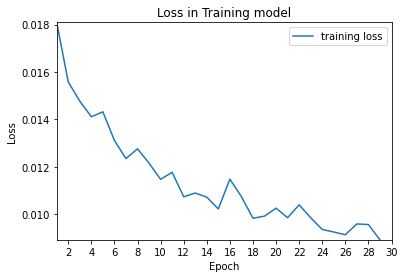

In [63]:
plt.plot(hist_GSPTSE.history['loss'])
plt.title('Loss in Training model')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,31,2))
plt.ylabel('Loss')
plt.xlim(1,epochs)
plt.ylim(train_loss3.min(),train_loss3[1])
plt.legend(['training loss'], loc= 'upper right')
plt.show()


Appending the past 100 days data values to the test dataset as to predict the 1st data in our dataset we will need the past 100 days as we have set the model with 100 days timestep. 

In [64]:
past_100_days_GSPTSE = GSPTSE_train.tail(100)
appended_GSPTSE_test = past_100_days_GSPTSE.append(GSPTSE_test)

Scaling the test data before doing the predictions. 

In [65]:
scaled_test_GSPTSE = sc.fit_transform(appended_GSPTSE_test)

scaled_test_GSPTSE.shape


(1679, 1)

Splitting the test data into sliding window time steps, like we did for the training data. 

Note: Here we can see the reason why we appened the past 60 days from the training dataset, we can now predict the price from the 1st day of the test dataset otherwise the function below will start predicting from the 61st day in the test dataset. 

In [66]:
X_test_GSPTSE = []
y_test_GSPTSE = []

for i in range(window,len(scaled_test_GSPTSE)):
    X_test_GSPTSE.append(scaled_test_GSPTSE[(i-window):i,0])
    y_test_GSPTSE.append(scaled_test_GSPTSE[i,0])

X_test_GSPTSE, y_test_GSPTSE = np.array(X_test_GSPTSE), np.array(y_test_GSPTSE)
X_test_GSPTSE = np.reshape(X_test_GSPTSE,(X_test_GSPTSE.shape[0], X_test_GSPTSE.shape[1],1))
X_test_GSPTSE.shape

(1579, 100, 1)

Data reshaping for prediction and plotting

In [67]:
#reshaping the data for prediction
X_test_GSPTSE = np.reshape(X_test_GSPTSE,(X_test_GSPTSE.shape[0], X_test_GSPTSE.shape[1],1))
y_test_GSPTSE = y_test_GSPTSE.reshape(-1,1)

print(X_test_GSPTSE.shape)
print(y_test_GSPTSE.shape)

(1579, 100, 1)
(1579, 1)


Predicting the price for the test 'labels' i.e. y-test values. 

In [68]:
#Predictions
y_train_predict_GSPTSE = model.predict(X_train_GSPTSE)
y_test_predict_GSPTSE = model.predict(X_test_GSPTSE)

50/50 [==============================] - 3s 51ms/step


Transforming the predicted values back to the unscaled form. 

In [73]:
#reshaping the train data
y_train_GSPTSE = y_train_GSPTSE.reshape(-1,1)

#transforming train set back to original form
predicted_train_GSPTSE = sc.inverse_transform(y_train_predict_GSPTSE)
train_GSPTSE = sc.inverse_transform(y_train_GSPTSE)

#transforming test set back to original form
predicted_GSPTSE= sc.inverse_transform(y_test_predict_GSPTSE)
test_GSPTSE= sc.inverse_transform(y_test_GSPTSE)


Creating a new column with the predicted values along with the actual closing price of the Test dataset and calculating the percentage difference between the prices. 

In [74]:
GSPTSE_test["Predicted"] = predicted_GSPTSE

def percentage_change(col1,col2):
    return (abs(col2 - col1) / col1) * 100

GSPTSE_test["Percentage_diff"] =  percentage_change(GSPTSE_test["Predicted"],GSPTSE_test["Close"]) 
GSPTSE_test

,Close,Predicted,Percentage_diff
Date,,,
2015-02-13,15264.79981,15117.841797,0.972083
2015-02-17,15284.59961,15156.293945,0.846550
2015-02-18,15212.79981,15193.195312,0.129035
2015-02-19,15180.29981,15214.881836,0.227291
2015-02-20,15172.20020,15216.690430,0.292378
...,...,...,...
2021-05-25,19564.09961,18771.583984,4.221890
2021-05-26,19745.50000,18771.125000,5.190818
2021-05-27,19774.40039,18748.554688,5.471599


Plotting the actual price vs the predicted price

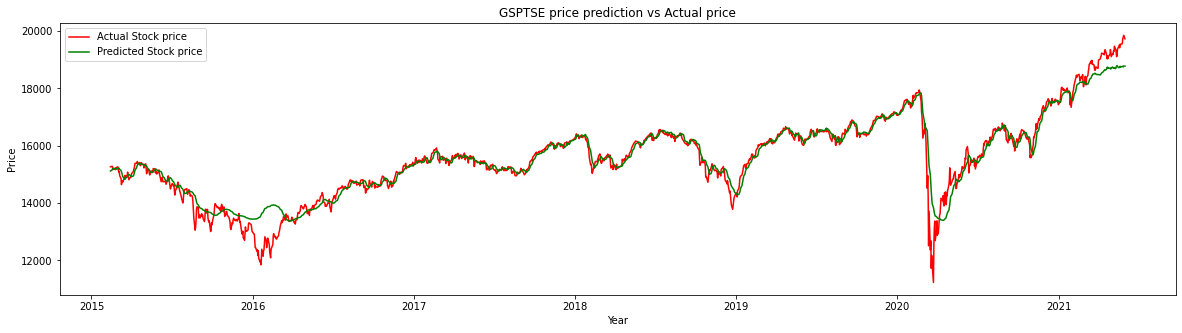

In [75]:
plt.figure(figsize= (20,5))
plt.plot(GSPTSE_test.index,GSPTSE_test["Close"], color = 'red', label = 'Actual Stock price')
plt.plot(GSPTSE_test["Predicted"], color = 'green', label = 'Predicted Stock price')
plt.title('GSPTSE price prediction vs Actual price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

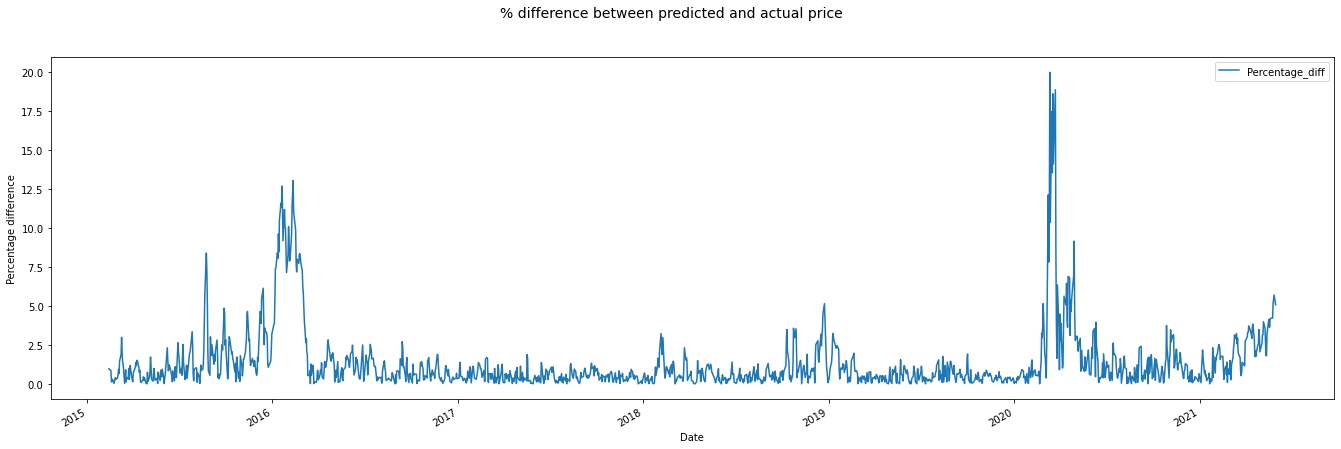

In [78]:
GSPTSE_test["Percentage_diff"].plot(figsize=(23,7),legend=True)
plt.suptitle('% difference between predicted and actual price', fontsize = 14)
plt.ylabel("Percentage difference")
plt.show()

Evaluating the model

In [79]:
#Finding the Root Mean Squared error on the predicted data

#Finding the Mean Squared error on the scaled testing data
print("Evaluating the training predictions:")
print("RMSE of the testing prediction:", math.sqrt(mean_squared_error(train_GSPTSE, predicted_train_GSPTSE)))
print("MAE of the testing prediction:", mean_absolute_error(train_GSPTSE, predicted_train_GSPTSE))
print()
#Finding the Mean Squared error on the unscaled testing data
print("Evaluating the testing predictions:")
print("RMSE of the testing prediction:", math.sqrt(mean_squared_error(test_GSPTSE, predicted_GSPTSE)))
print("MAE of the testing prediction:", mean_absolute_error(test_GSPTSE, predicted_GSPTSE))

Evaluating the training predictions:
RMSE of the testing prediction: 59.99477465363954
MAE of the testing prediction: 44.16300703140374

Evaluating the testing predictions:
RMSE of the testing prediction: 359.12191812552356
MAE of the testing prediction: 201.36771018465015


## Conclusion
   This project in no means is ready for the real world market prediction, as stock market are dependent on variou other external factors. Including, geo-political news, seasonality, company news, etc.,  to name a few. Instead it was created fore academic purpose only. 